# Load and check data

In [1]:
import time
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("whitegrid")

import nltk

from sklearn import metrics, model_selection, naive_bayes
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

import xgboost as xgb

/home/guido/.conda/envs/dl/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Load in the train and test datasets
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

full_data = [train, test]

train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [3]:
# Explore the dataset 
print("Number of rows in train dataset {}".format(train.shape[0]))
print("Number of rows in test dataset {}".format(test.shape[0]))
print("No duplicates in train data") if train.shape[
    0] == train.text.unique().__len__() else print("Oops")
print("No duplicates in test data") if test.shape[
    0] == test.text.unique().__len__() else print("Oops")
print("Unique author is data {}".format(train.author.unique()))
print("Number of nulls in the train is {} and text is {}".format(
    train.isnull().sum().sum(), test.isnull().sum().sum()))

Number of rows in train dataset 19579
Number of rows in test dataset 8392
No duplicates in train data
No duplicates in test data
Unique author is data ['EAP' 'HPL' 'MWS']
Number of nulls in the train is 0 and text is 0


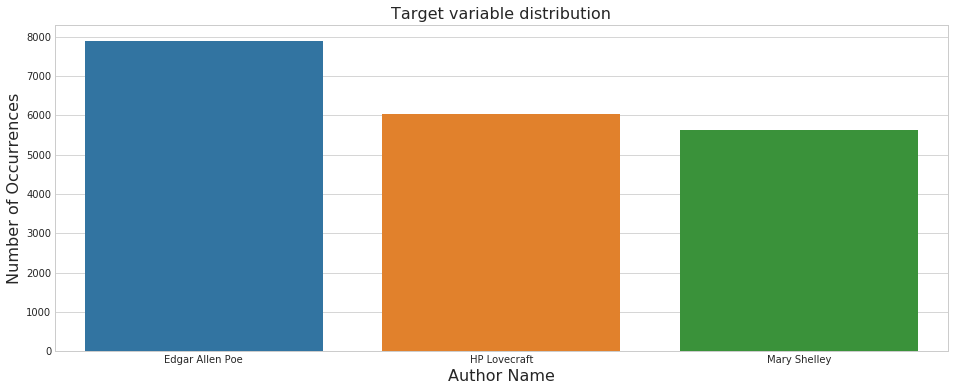

In [4]:
z = {'EAP': 'Edgar Allen Poe', 'MWS': 'Mary Shelley', 'HPL': 'HP Lovecraft'}
plt.figure(figsize=(16, 6))
plt.title('Target variable distribution', fontsize=16)
plt.ylabel('Number of Occurrences', fontsize=16)
plt.xlabel('Author Name', fontsize=16)
sns.barplot(
    x=train.author.map(z).unique(), y=train.author.value_counts().values)

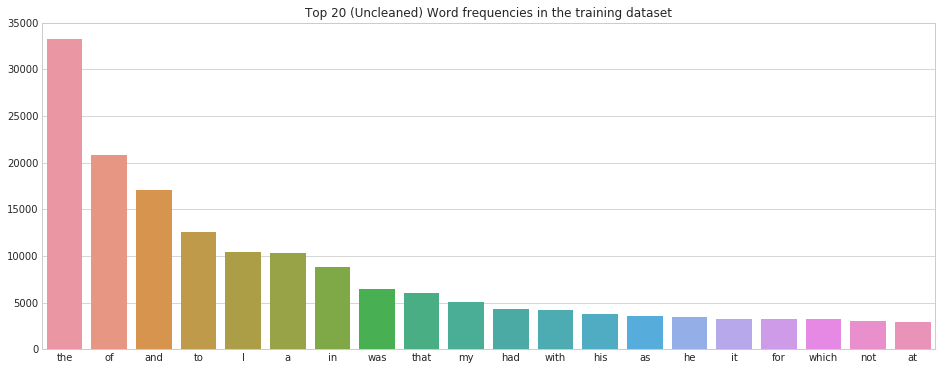

In [5]:
all_words = train['text'].str.split(expand=True).unstack().value_counts()
plt.figure(figsize=(16, 6))
plt.title('Top 20 (Uncleaned) Word frequencies in the training dataset')
sns.barplot(x=all_words.index.values[:20], y=all_words.values[:20])

# Wordclouds

# Natural Language Processing

## Tokenization

In [6]:
# Storing the first text element as a string
first_text = train.text.values[0]
print(first_text)
print("="*90)
print(first_text.split(" "))

This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.
['This', 'process,', 'however,', 'afforded', 'me', 'no', 'means', 'of', 'ascertaining', 'the', 'dimensions', 'of', 'my', 'dungeon;', 'as', 'I', 'might', 'make', 'its', 'circuit,', 'and', 'return', 'to', 'the', 'point', 'whence', 'I', 'set', 'out,', 'without', 'being', 'aware', 'of', 'the', 'fact;', 'so', 'perfectly', 'uniform', 'seemed', 'the', 'wall.']


In [7]:
first_text_list = nltk.word_tokenize(first_text)
print(first_text_list)

['This', 'process', ',', 'however', ',', 'afforded', 'me', 'no', 'means', 'of', 'ascertaining', 'the', 'dimensions', 'of', 'my', 'dungeon', ';', 'as', 'I', 'might', 'make', 'its', 'circuit', ',', 'and', 'return', 'to', 'the', 'point', 'whence', 'I', 'set', 'out', ',', 'without', 'being', 'aware', 'of', 'the', 'fact', ';', 'so', 'perfectly', 'uniform', 'seemed', 'the', 'wall', '.']


## Stopword Removal

In [8]:
stopwords = nltk.corpus.stopwords.words('english')
len(stopwords)

153

In [9]:
first_text_list_cleaned = [
    word for word in first_text_list if word.lower() not in stopwords
]
print(first_text_list_cleaned)
print("=" * 90)
print("Length of original list: {} words\n"
      "Length of list after stopwords removal: {} words".format(
          len(first_text_list), len(first_text_list_cleaned)))

['process', ',', 'however', ',', 'afforded', 'means', 'ascertaining', 'dimensions', 'dungeon', ';', 'might', 'make', 'circuit', ',', 'return', 'point', 'whence', 'set', ',', 'without', 'aware', 'fact', ';', 'perfectly', 'uniform', 'seemed', 'wall', '.']
Length of original list: 48 words
Length of list after stopwords removal: 28 words


## Stemming and Lemmatization

In [10]:
stemmer = nltk.stem.PorterStemmer()
print("The stemmed form of running is: {}".format(stemmer.stem("running")))
print("The stemmed form of runs is: {}".format(stemmer.stem("runs")))
print("The stemmed form of run is: {}".format(stemmer.stem("run")))

print("The stemmed form of leaves is: {}".format(stemmer.stem("leaves")))

The stemmed form of running is: run
The stemmed form of runs is: run
The stemmed form of run is: run
The stemmed form of leaves is: leav


In [11]:
lemm =  nltk.stem.WordNetLemmatizer()
print("The lemmatized form of leaves is: {}".format(lemm.lemmatize("leaves")))

The lemmatized form of leaves is: leaf


## Vectorizing Raw Text

In [12]:
# Defining our sentence
sentence = ["I love to eat Burgers", "I love to eat Fries"]
# try CountVectorizer
vectorizer = CountVectorizer(min_df=0)
sentence_transform = vectorizer.fit_transform(sentence)

print("The features are:\n {}".format(vectorizer.get_feature_names()))
print("\nThe vectorized array looks like:\n {}".format(
    sentence_transform.toarray()))

The features are:
 ['burgers', 'eat', 'fries', 'love', 'to']

The vectorized array looks like:
 [[1 1 0 1 1]
 [0 1 1 1 1]]


In [13]:
sentence = ["I love to eat Burgers", "I love to eat Fries"]
# try  TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=0)
sentence_transform = vectorizer.fit_transform(sentence)

print("The features are:\n {}".format(vectorizer.get_feature_names()))
print("\nThe vectorized array looks like:\n {}".format(
    sentence_transform.toarray()))

The features are:
 ['burgers', 'eat', 'fries', 'love', 'to']

The vectorized array looks like:
 [[ 0.63009934  0.44832087  0.          0.44832087  0.44832087]
 [ 0.          0.44832087  0.63009934  0.44832087  0.44832087]]


# Feature Engineering

## some features

In [14]:
import string


def word_count(raw):
    return len(raw['text'].split())


def char_count(raw):
    return len(raw['text'])


def unique_word_fraction(raw):
    text = raw['text'].lower()
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    unique_word_count = len(list(set(text_list)))
    word_count = len(text_list)
    return unique_word_count / word_count


def stopwords_count(raw):
    text = raw['text'].lower()
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    stopwords = nltk.corpus.stopwords.words('english')

    stopwords_count = len([w for w in text_list if w in stopwords])
    word_count = len(text_list)
    return stopwords_count / word_count


def punctuations_fraction(raw):
    text = raw['text'].lower()
    text_list = nltk.word_tokenize(text)

    punctuation_count = len([w for w in text_list if w in string.punctuation])
    char_count = len(text)
    return punctuation_count / char_count

In [15]:
for dataset in full_data:
    dataset['word_count'] = dataset.apply(lambda raw: word_count(raw), axis=1)
    dataset['char_count'] = dataset.apply(lambda raw: char_count(raw), axis=1)
    dataset['unique_word_fraction'] = dataset.apply(lambda raw: unique_word_fraction(raw), axis=1)
    dataset['stopwords_count'] = dataset.apply(lambda raw: stopwords_count(raw), axis=1)
    dataset['punctuations_fraction'] = dataset.apply(lambda raw: punctuations_fraction(raw), axis=1)

In [16]:
print(train.shape, test.shape)
train.head()

(19579, 8) (8392, 7)


,id,text,author,word_count,char_count,unique_word_fraction,stopwords_count,punctuations_fraction
0,id26305,"This process, however, afforded me no means of...",EAP,41,231,0.853659,0.487805,0.030303
1,id17569,It never once occurred to me that the fumbling...,HPL,14,71,1.000000,0.571429,0.014085
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,36,200,0.888889,0.472222,0.025000
3,id27763,How lovely is spring As we looked from Windsor...,MWS,34,206,0.911765,0.382353,0.019417
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,27,174,0.925926,0.407407,0.022989


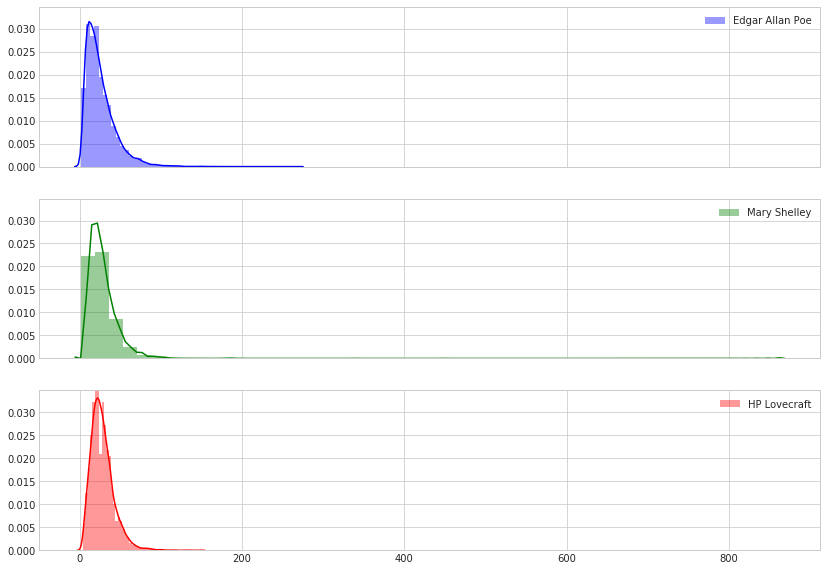

In [17]:
fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True, figsize=(14, 10))
sns.distplot(
    train.loc[train['author'] == 'EAP']['word_count'].values,
    ax=ax[0],
    color='blue',
    label='Edgar Allan Poe')
sns.distplot(
    train.loc[train['author'] == 'MWS']['word_count'].values,
    ax=ax[1],
    color='green',
    label='Mary Shelley')
sns.distplot(
    train.loc[train['author'] == 'HPL']['word_count'].values,
    ax=ax[2],
    color='red',
    label='HP Lovecraft')
ax[0].legend(loc=0)
ax[1].legend(loc=0)
ax[2].legend(loc=0)

## naive bayes features

In [18]:
author_mapping_dict = {'EAP': 0, 'HPL': 1, 'MWS': 2}
y_train = train['author'].map(author_mapping_dict)

drop_elements = ['id', 'text']
x_train = train.drop(drop_elements + ['author'], axis=1)
x_test = test.drop(drop_elements, axis=1)

print(x_train.shape, test.shape)
x_train.head()

(19579, 5) (8392, 7)


,word_count,char_count,unique_word_fraction,stopwords_count,punctuations_fraction
0,41,231,0.853659,0.487805,0.030303
1,14,71,1.000000,0.571429,0.014085
2,36,200,0.888889,0.472222,0.025000
3,34,206,0.911765,0.382353,0.019417
4,27,174,0.925926,0.407407,0.022989


In [19]:
def runMNB(x_train, y_train, x_val, x_test):
    model = naive_bayes.MultinomialNB()
    model.fit(x_train, y_train)
    pred_y_val = model.predict_proba(x_val)
    pred_y_test = model.predict_proba(x_test)
    return pred_y_val, pred_y_test, model

In [20]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 3))
tfidf_train = tfidf_vectorizer.fit_transform(train['text'].values.tolist())
tfidf_test = tfidf_vectorizer.transform(test['text'].values.tolist())

n_splits = 5
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 3])
kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=2017)

for idx_dev, idx_val in kf.split(tfidf_train):
    x_dev, x_val = tfidf_train[idx_dev], tfidf_train[idx_val]
    y_dev, y_val = y_train[idx_dev], y_train[idx_val]
    pred_y_val, pred_y_test, model = runMNB(x_dev, y_dev, x_val, tfidf_test)
    pred_full_test = pred_full_test + pred_y_test
    pred_train[idx_val, :] = pred_y_val
    cv_scores.append(metrics.log_loss(y_val, pred_y_val))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / float(n_splits)

# add the predictions as new features
train["nb_cvec_eap"] = pred_train[:, 0]
train["nb_cvec_hpl"] = pred_train[:, 1]
train["nb_cvec_mws"] = pred_train[:, 2]
test["nb_cvec_eap"] = pred_full_test[:, 0]
test["nb_cvec_hpl"] = pred_full_test[:, 1]
test["nb_cvec_mws"] = pred_full_test[:, 2]

Mean cv score :  0.835464376712


In [21]:
tf_vectorizer = CountVectorizer(stop_words='english', ngram_range=(1, 3))
tf_vectorizer.fit(train['text'].values.tolist())
tf_train = tf_vectorizer.transform(train['text'].values.tolist())
tf_test = tf_vectorizer.transform(test['text'].values.tolist())

n_splits = 5
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 3])
kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=2017)

for idx_dev, idx_val in kf.split(tf_train):
    x_dev, x_val = tf_train[idx_dev], tf_train[idx_val]
    y_dev, y_val = y_train[idx_dev], y_train[idx_val]
    pred_y_val, pred_y_test, model = runMNB(x_dev, y_dev, x_val, tf_test)
    pred_full_test = pred_full_test + pred_y_test
    pred_train[idx_val, :] = pred_y_val
    cv_scores.append(metrics.log_loss(y_val, pred_y_val))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / float(n_splits)

# add the predictions as new features
train["nb_cvec_eap"] = pred_train[:, 0]
train["nb_cvec_hpl"] = pred_train[:, 1]
train["nb_cvec_mws"] = pred_train[:, 2]
test["nb_cvec_eap"] = pred_full_test[:, 0]
test["nb_cvec_hpl"] = pred_full_test[:, 1]
test["nb_cvec_mws"] = pred_full_test[:, 2]

Mean cv score :  0.453892575699


## Tf-idf features

In [22]:
lemm = nltk.stem.WordNetLemmatizer()


class LemmCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmCountVectorizer, self).build_analyzer()
        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))


class LemmTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmTfidfVectorizer, self).build_analyzer()
        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))

In [23]:
tf_vectorizer = LemmCountVectorizer(stop_words='english', ngram_range=(1,3))
#tf_vectorizer = CountVectorizer(stop_words='english', ngram_range=(1, 3))
tf_train = tf_vectorizer.fit_transform(train['text'].values.tolist())
tf_test = tf_vectorizer.transform(test['text'].values.tolist())

In [24]:
tfidf_vectorizer = LemmTfidfVectorizer(stop_words='english', ngram_range=(1, 5))
tfidf_train = tfidf_vectorizer.fit_transform(train['text'].values.tolist())
tfidf_test = tfidf_vectorizer.transform(test['text'].values.tolist())

In [25]:
print(train.shape, test.shape)

(19579, 11) (8392, 10)


In [26]:
#start = time.time()
#
#n_comp = 400
#svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack', random_state=2017)
#svd_obj.fit(tfidf_train)
#svd_train = pd.DataFrame(svd_obj.transform(tf_train))
#svd_test = pd.DataFrame(svd_obj.transform(tf_test))
#
#svd_train.columns = ['svd_word_' + str(i) for i in range(n_comp)]
#svd_test.columns = ['svd_word_' + str(i) for i in range(n_comp)]
#train = pd.concat([train, svd_train], axis=1)
#test = pd.concat([test, svd_test], axis=1)
#
#end = time.time()
#print("Time taken in tf-idf is {}.".format(end - start))

In [27]:
start = time.time()

n_comp = 400
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack', random_state=2017)
#svd_obj.fit(tfidf_train)
svd_train = pd.DataFrame(svd_obj.fit_transform(tfidf_train))
svd_test = pd.DataFrame(svd_obj.transform(tfidf_test))

svd_train.columns = ['svd_char_' + str(i) for i in range(n_comp)]
svd_test.columns = ['svd_char_' + str(i) for i in range(n_comp)]
train = pd.concat([train, svd_train], axis=1)
test = pd.concat([test, svd_test], axis=1)

end = time.time()
print("Time taken in tf-idf is {}.".format(end - start))

Time taken in tf-idf is 65.28149509429932.


In [28]:
print(train.shape, test.shape)
train.head()

(19579, 411) (8392, 410)


,id,text,author,word_count,char_count,unique_word_fraction,stopwords_count,punctuations_fraction,nb_cvec_eap,nb_cvec_hpl,...,svd_char_390,svd_char_391,svd_char_392,svd_char_393,svd_char_394,svd_char_395,svd_char_396,svd_char_397,svd_char_398,svd_char_399
0,id26305,"This process, however, afforded me no means of...",EAP,41,231,0.853659,0.487805,0.030303,9.999894e-01,4.065931e-06,...,-0.005562,0.008264,-0.002542,0.014016,0.001995,-0.001521,-0.009520,0.000202,-0.002278,-0.004925
1,id17569,It never once occurred to me that the fumbling...,HPL,14,71,1.000000,0.571429,0.014085,8.112629e-01,1.583722e-01,...,-0.035802,0.006360,-0.007376,-0.030178,0.002564,-0.014688,0.008747,0.039815,-0.020141,0.003364
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,36,200,0.888889,0.472222,0.025000,9.999873e-01,1.267926e-05,...,-0.009188,0.035607,0.014287,-0.000629,-0.011040,0.010444,0.006669,0.015396,0.011051,-0.004965
3,id27763,How lovely is spring As we looked from Windsor...,MWS,34,206,0.911765,0.382353,0.019417,7.761739e-10,6.212832e-10,...,0.000212,-0.008549,0.002516,-0.005813,0.001378,0.006148,0.001463,0.002236,0.006745,0.004830
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,27,174,0.925926,0.407407,0.022989,8.629272e-01,1.337367e-01,...,0.014072,0.005710,-0.003203,0.000462,0.001064,0.000209,-0.012035,0.009865,-0.000339,0.006922


## lda

In [20]:
# Define helper function to print top words
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = ("\nTopic #{}: ").format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
        print("="*70)

In [21]:
lda = LatentDirichletAllocation(
    n_components=10,
    max_iter=5,
    learning_method='online',
    learning_offset=50.,
    random_state=0)

In [22]:
#lda.fit(tfidf_train)
lda.fit(tf_train)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50.0,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_components=10, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [23]:
n_top_words = 20
print("Topics in LDA model: ")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(lda, tfidf_feature_names, n_top_words)

Topics in LDA model: 

Topic #0: admiralty court streets admiration pity especially events nineteenth ah dearest friend action lingered account properly belong period life abstract conception account circumstances brought neglect father accomplished loss advanced truth argument acolyte bear brimming advanced bore small afterward reproduced associated advances time exuberant act hesitation vanished acquired knowledge addition raymond dispelled adduced support idea articles adorn mind person man fitted account patient condition acetylene headlight despite attention

Topic #1: adjoining staircase arrested attention addressed english voice affection undisturbed unchecked fear opened accompanied apparent rapid subsidence admonition singular low agreed understand passages act previous act accommodation man accompanied actions arising aged father adrian visited london came ah bon acts recovery agreed virtual identity phrase agora abnormal looking address noble persons mentioned husband absolu

In [24]:
first_topic = lda.components_[0]
second_topic = lda.components_[1]
third_topic = lda.components_[2]

first_topic.shape

(13781,)

In [25]:
first_topic_words = [
    tfidf_feature_names[i] for i in first_topic.argsort()[:-50 - 1:-1]
]
second_topic_words = [
    tfidf_feature_names[i] for i in second_topic.argsort()[:-50 - 1:-1]
]
third_topic_words = [
    tfidf_feature_names[i] for i in third_topic.argsort()[:-50 - 1:-1]
]

In [26]:
for i in first_topic.argsort()[:-50 - 1:-1]:
    print(i)

7637
7730
13750
5618
3911
1936
3673
3222
9157
4785
9032
11688
9198
5324
5095
7000
7292
8367
3856
4573
139
11224
7394
11997
2745
13527
7623
6099
5252
846
4334
1472
2613
3248
5599
7299
2224
5479
11791
13511
13697
1394
7851
8326
5432
8416
5402
421
10506
12061


## SVD decomposition

In [29]:
n_comp = 400
svd = TruncatedSVD(n_components=n_comp, algorithm='arpack', random_state=2017)
lsa = make_pipeline(svd, Normalizer(copy=False))

lsa_tfidf_train = lsa.fit_transform(tfidf_train)
lsa_tfidf_test = lsa.transform(tfidf_test)

In [30]:
#lsa_tf_train_df = pd.DataFrame(lsa_tf_train)
#lsa_tf_test_df = pd.DataFrame(lsa_tf_test)
#lsa_tf_train_df.columns = ['lsa_tf_' + str(i) for i in range(n_comp)]
#lsa_tf_test_df.columns = ['lsa_tf_' + str(i) for i in range(n_comp)]

lsa_tfidf_train_df = pd.DataFrame(lsa_tfidf_train)
lsa_tfidf_test_df = pd.DataFrame(lsa_tfidf_test)
lsa_tfidf_train_df.columns = ['lsa_tfidf_' + str(i) for i in range(n_comp)]
lsa_tfidf_test_df.columns = ['lsa_tfidf_' + str(i) for i in range(n_comp)]

#train = pd.concat([train, lsa_tf_train_df], axis=1)
#test = pd.concat([test, lsa_tf_test_df], axis=1)

train = pd.concat([train, lsa_tfidf_train_df], axis=1)
test = pd.concat([test, lsa_tfidf_test_df], axis=1)

train.head()

,id,text,author,word_count,char_count,unique_word_fraction,stopwords_count,punctuations_fraction,lsa_tfidf_0,lsa_tfidf_1,...,lsa_tfidf_390,lsa_tfidf_391,lsa_tfidf_392,lsa_tfidf_393,lsa_tfidf_394,lsa_tfidf_395,lsa_tfidf_396,lsa_tfidf_397,lsa_tfidf_398,lsa_tfidf_399
0,id26305,"This process, however, afforded me no means of...",EAP,41,231,0.853659,0.487805,0.030303,0.139840,-0.007251,...,0.000643,-0.006058,-0.019385,-0.006768,0.025770,-0.011014,0.008027,0.005641,-0.005337,-0.008757
1,id17569,It never once occurred to me that the fumbling...,HPL,14,71,1.000000,0.571429,0.014085,0.121417,-0.017047,...,0.060658,0.010534,-0.016033,0.074337,0.019329,-0.049497,-0.017260,0.062045,0.006726,0.048931
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,36,200,0.888889,0.472222,0.025000,0.178419,-0.038070,...,0.030911,-0.011846,-0.056019,-0.000116,0.008165,-0.095923,-0.011373,0.009266,0.027478,0.040254
3,id27763,How lovely is spring As we looked from Windsor...,MWS,34,206,0.911765,0.382353,0.019417,0.159391,-0.042417,...,0.020050,0.051008,-0.011462,0.047212,0.040565,-0.027978,-0.003310,-0.070083,0.033151,-0.042343
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,27,174,0.925926,0.407407,0.022989,0.129984,-0.043377,...,0.001220,-0.075847,-0.041770,-0.038500,0.051331,0.033825,-0.044747,-0.006587,0.037715,0.110825


## sentiment features

# Visualisations

In [ ]:
sns.violinplot(x = 'author', y='word_count', data=train)

# Ensembling & Stacking models

In [30]:
author_mapping_dict = {'EAP': 0, 'HPL': 1, 'MWS': 2}
y_train = train['author'].map(author_mapping_dict)

drop_elements = ['id', 'text']
x_train = train.drop(drop_elements + ['author'], axis=1)
x_test = test.drop(drop_elements, axis=1)

print(x_train.shape, x_test.shape)
x_train.head()

(19579, 408) (8392, 408)


,word_count,char_count,unique_word_fraction,stopwords_count,punctuations_fraction,nb_cvec_eap,nb_cvec_hpl,nb_cvec_mws,svd_char_0,svd_char_1,...,svd_char_390,svd_char_391,svd_char_392,svd_char_393,svd_char_394,svd_char_395,svd_char_396,svd_char_397,svd_char_398,svd_char_399
0,41,231,0.853659,0.487805,0.030303,9.999894e-01,4.065931e-06,6.573423e-06,0.016435,-0.018263,...,-0.005562,0.008264,-0.002542,0.014016,0.001995,-0.001521,-0.009520,0.000202,-0.002278,-0.004925
1,14,71,1.000000,0.571429,0.014085,8.112629e-01,1.583722e-01,3.036484e-02,0.006266,-0.007741,...,-0.035802,0.006360,-0.007376,-0.030178,0.002564,-0.014688,0.008747,0.039815,-0.020141,0.003364
2,36,200,0.888889,0.472222,0.025000,9.999873e-01,1.267926e-05,1.882039e-08,0.015630,-0.020010,...,-0.009188,0.035607,0.014287,-0.000629,-0.011040,0.010444,0.006669,0.015396,0.011051,-0.004965
3,34,206,0.911765,0.382353,0.019417,7.761739e-10,6.212832e-10,1.000000e+00,0.015848,-0.021321,...,0.000212,-0.008549,0.002516,-0.005813,0.001378,0.006148,0.001463,0.002236,0.006745,0.004830
4,27,174,0.925926,0.407407,0.022989,8.629272e-01,1.337367e-01,3.336066e-03,0.006623,-0.009987,...,0.014072,0.005710,-0.003203,0.000462,0.001064,0.000209,-0.012035,0.009865,-0.000339,0.006922


In [31]:
from sklearn.model_selection import train_test_split
xtr, xv, ytr, yv = train_test_split(
    x_train.values, y_train, test_size=0.2, random_state=1987)
dtrain = xgb.DMatrix(xtr, label=ytr)
dvalid = xgb.DMatrix(xv, label=yv)
dtest = xgb.DMatrix(x_test.values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

xgb_par = {
    'min_child_weight': 1,
    'eta': 0.1,
    'colsample_bytree': 0.7,
    'max_depth': 3,
    'subsample': 0.8,
    'lambda': 2.0,
    'nthread': -1,
    'silent': 1,
    'eval_metric': "mlogloss",
    'objective': 'multi:softprob',
    'num_class': 3
}

model_1 = xgb.train(
    xgb_par,
    dtrain,
    1000,
    watchlist,
    early_stopping_rounds=50,
    maximize=False,
    verbose_eval=40)
print('Modeling RMSLE %.5f' % model_1.best_score)

[0]	train-mlogloss:1.02398	valid-mlogloss:1.0248
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 50 rounds.
[40]	train-mlogloss:0.394755	valid-mlogloss:0.410981
[80]	train-mlogloss:0.351184	valid-mlogloss:0.386754
[120]	train-mlogloss:0.322229	valid-mlogloss:0.380563
[160]	train-mlogloss:0.298087	valid-mlogloss:0.378957
[200]	train-mlogloss:0.277681	valid-mlogloss:0.377584
[240]	train-mlogloss:0.258431	valid-mlogloss:0.377373
[280]	train-mlogloss:0.241424	valid-mlogloss:0.378394
Stopping. Best iteration:
[253]	train-mlogloss:0.252692	valid-mlogloss:0.377157

Modeling RMSLE 0.37716


In [32]:
print(x_train.shape, x_test.shape)

(19579, 408) (8392, 408)


In [33]:
yvalid = model_1.predict(dvalid)
ytest = model_1.predict(dtest)

In [35]:
if test.shape[0] == ytest.shape[0]:
    print('Test shape OK.') 
test_id = test['id'].values
out_df = pd.DataFrame(ytest)
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.insert(0, 'id', test_id)
out_df.to_csv("../result/submission-20171123-05.csv", index=False)

Test shape OK.
